In [1]:
import os
if "datasets.ipynb" in os.listdir():
    os.chdir("../")
print("Running in {}".format(os.getcwd()))

Running in /data/hpcdata/users/anddon76/icenet/icenet-experimental


# Test Run an Image-to-Image Pipeline with HF Diffusers

## 1. Configure Image-to-Image Pipeline
Following the below HuggingFace tutorial:
- [Image-to-image](https://huggingface.co/docs/diffusers/using-diffusers/img2img)

In [2]:
import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import make_image_grid, load_image

# set up pipeline
pipeline = AutoPipelineForImage2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipeline.enable_model_cpu_offload()

2024-01-25 17:29:09.722870: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 17:29:09.763964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 17:29:09.763999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 17:29:09.765032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 17:29:09.773247: I tensorflow/core/platform/cpu_feature_guar

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
# set up dataset
from utils import IceNetDataSetPyTorch
dataset_config = "dataset_config.single_month.json"
train_ds = IceNetDataSetPyTorch(dataset_config, "train", batch_size=2, shuffling=True)
val_ds = IceNetDataSetPyTorch(dataset_config, "val", batch_size=2, shuffling=False)
test_ds = IceNetDataSetPyTorch(dataset_config, "test", batch_size=2, shuffling=False)

In [4]:
train_ds[0][0].shape, train_ds[0][1].shape

/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(torch.Size([9, 432, 432]), torch.Size([1, 432, 432]))

In [5]:
# modify autoencoder to have proper number of i/o channels
pipeline.vae.encoder.conv_in, pipeline.vae.decoder.conv_out

(Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))

In [6]:
from torch import nn
in_channels = 9
mid_channels = 128
out_channels = 1
pipeline.vae.encoder.conv_in = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels,
                                         kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
pipeline.vae.decoder.conv_out = nn.Conv2d(in_channels=mid_channels, out_channels=out_channels,
                                          kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [7]:
pipeline.vae.encoder.conv_in, pipeline.vae.decoder.conv_out

(Conv2d(9, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))

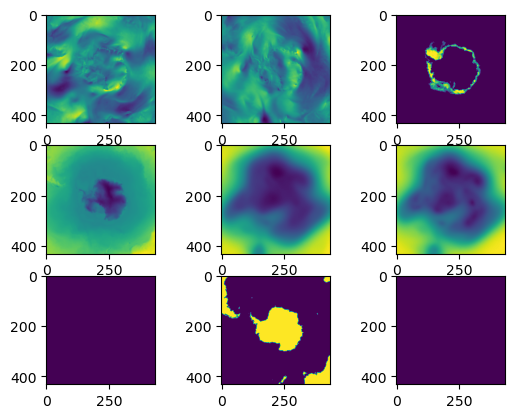

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(train_ds[0][0][3*i + j, :, :])
plt.show()

In [17]:
# test entire pipeline
with torch.autocast(device_type="cuda"):
    init_image = train_ds[0][0]
    output = pipeline("", image=init_image)
    image = output.images[0]

/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/diffusers/image_processor.py:546: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(


  0%|          | 0/40 [00:00<?, ?it/s]

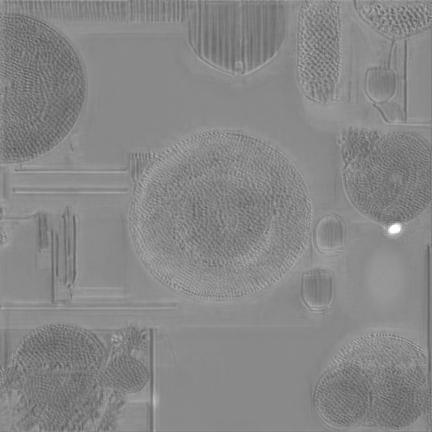

In [18]:
image

In [19]:
import numpy as np
np.array(image).shape

(432, 432)

## 2. Deconstruct Pipeline for Better Understanding
Following the below HuggingFace tutorial:
- [Understanding pipelines, models and schedulers](https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline)

It's helpful to have an overview of the StableDiffusion pipeline architecture we consider as we walk through the section below. Note that we ignore the text encoder and prompt in our case and pass in zeros of shape `(batch_size, sequence_length=1, embedding_dim=768)` for the text embeddings. In the future, however, one could finetune the text embedding component of this architecture to prompt different forecast styles, e.g., "high ice" or "low ice" or "high ice in beaufort sea and low ice in barents sea" forecasts.

![](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png)

### 2.1 Conditioning noised image → Encoded latent noised image

In [37]:
# conditioning noised image -> encoded latent noised image
with torch.autocast(device_type="cuda"):
    z = pipeline.vae.encode(init_image.to(torch.half).to("cuda").unsqueeze(0))
z

AutoencoderKLOutput(latent_dist=<diffusers.models.autoencoders.vae.DiagonalGaussianDistribution object at 0x7f534cea66d0>)

In [24]:
# original noised image > encoded latent noised image
encoded_image = z.latent_dist.mode()
encoded_image.shape

torch.Size([1, 4, 54, 54])

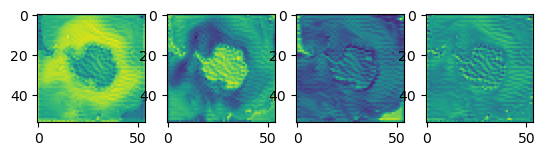

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4)
mat = encoded_image.detach().cpu().numpy()
for i in range(4):
    ax[i].imshow(mat[0, i, :, :])
plt.show()

### 2.2 Encoded latent noised image → Encoded latent denoised image

In [30]:
# encoded latent noised image -> encoded latent denoised image
with torch.autocast(device_type="cuda"):
    encoded_output = pipeline.unet(encoded_image, timestep=40, encoder_hidden_states=torch.zeros((1, 1, 768)))
encoded_output

UNet2DConditionOutput(sample=tensor([[[[-1.2051e+00, -6.7461e+00, -4.2461e+00,  ..., -8.7256e-01,
           -2.5254e+00, -2.9863e+00],
          [-1.5625e+00, -2.8926e+00, -1.6934e+00,  ..., -2.7461e+00,
           -9.2812e+00, -2.1797e+00],
          [-2.8066e+00, -3.0918e+00, -8.1787e-01,  ..., -1.1221e+00,
           -8.4375e-01, -1.3398e+00],
          ...,
          [ 1.2817e-01, -1.8584e+00, -2.1680e+00,  ..., -3.5000e+00,
           -4.4297e+00, -2.6309e+00],
          [ 9.2627e-01, -2.2424e-01, -2.8125e-01,  ..., -2.3438e+00,
           -4.8320e+00, -1.0234e+00],
          [ 7.0801e-02,  1.6562e+00,  1.0706e-01,  ..., -1.4814e+00,
           -1.5566e+00, -4.2334e-01]],

         [[ 1.2219e-01,  1.6787e+00,  1.2344e+00,  ...,  1.1589e-02,
            1.7295e+00,  1.0439e+00],
          [ 3.2051e+00,  2.3242e+00,  8.4521e-01,  ..., -5.8301e-01,
            1.1826e+00,  2.7871e+00],
          [ 1.8237e-01,  1.3145e+00, -7.6514e-01,  ...,  3.0762e+00,
            1.4678e+00,  8.52

In [31]:
encoded_output.sample.shape

torch.Size([1, 4, 54, 54])

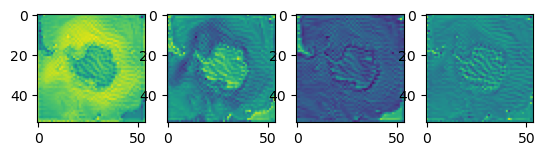

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4)
mat = encoded_output.sample.detach().cpu().numpy()
for i in range(4):
    ax[i].imshow(mat[0, i, :, :])
plt.show()

### 2.3 Encoded latent denoised image → Denoised image (forecast)

In [34]:
# encoded latent denoised image -> denoised image
with torch.autocast(device_type="cuda"):
    output = pipeline.vae.decoder(encoded_output.sample)
output

tensor([[[[-0.0441, -0.0416, -0.0305,  ..., -0.0438, -0.0964,  0.0358],
          [-0.1290, -0.0843,  0.0213,  ...,  0.0024, -0.0319,  0.0676],
          [-0.1888, -0.0629, -0.0632,  ...,  0.0573,  0.0130,  0.1052],
          ...,
          [-0.1647,  0.0243,  0.0949,  ..., -0.0795,  0.0062,  0.0958],
          [-0.0922,  0.1221,  0.0030,  ...,  0.0056,  0.0368,  0.0383],
          [-0.0757,  0.0206,  0.0043,  ..., -0.0963,  0.0410, -0.0019]]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ConvolutionBackward0>)

In [35]:
output.shape

torch.Size([1, 1, 432, 432])

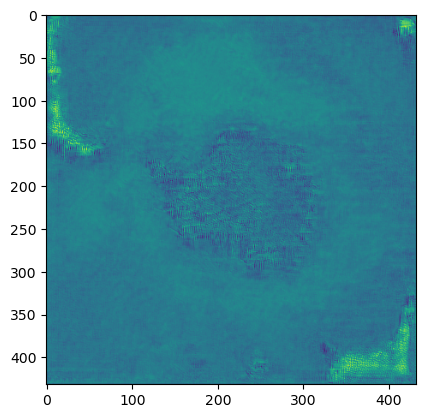

In [36]:
mat = output.detach().cpu().numpy()
plt.imshow(mat[0, 0, :, :])

## 3. Finetune model pipeline

Now, we follow the below HuggingFace tutorial to finetune the entire model pipeline (VAE + UNet). 
- [Train a diffusion model](https://huggingface.co/docs/diffusers/tutorials/basic_training)

In [80]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 432  # the generated image resolution, must match training dataset size
    in_channels = 9
    out_channels = 1
    train_batch_size = 2
    eval_batch_size = 2  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "results/diffusion.img2img"  # the model name locally and on the HF Hub
    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = False  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [65]:
import torch
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=config.train_batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=config.eval_batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=config.eval_batch_size, shuffle=False)

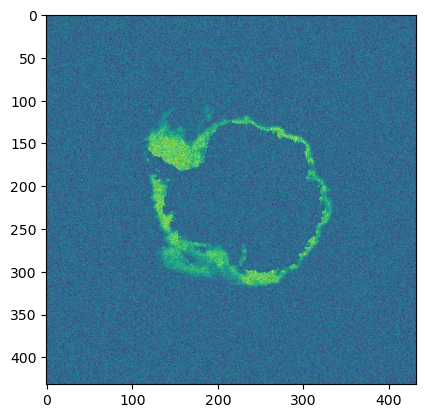

In [77]:
from PIL import Image
from diffusers import DDPMScheduler

# demonstrate partial noising
init_target = train_ds[0][1]
noise_noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(init_target.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(init_target, noise, timesteps)
plt.imshow(noisy_image.squeeze().numpy())

In [ ]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [81]:
generator = torch.manual_seed(0)  # Seed generator to create the initial latent noise
latents = torch.randn(
    (config.train_batch_size, config.in_channels, config.image_size // 8, config.image_size // 8),
    generator=generator,
    device=pipeline.device,
)
latents = latents * noise_scheduler.init_noise_sigma

In [82]:
pipeline.unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320

In [ ]:
from tqdm.auto import tqdm

for t in tqdm(noise_scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = noise_scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample